In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


from  utils.preprocessing_utils import parse_data,build_dataframe_from_json,get_rows_containing_label,get_most_frequent_words
import utils.plot_utils as pltUtils
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from utils.source_code_feature_extractor import SourceCodeFeatureExtractor
from scipy.sparse import hstack, csr_matrix
from utils.training_config import TrainingConfig
from utils.training_utils import analyze_tag_confusions,multilabel_stratified_split,multilabel_oversample,bar_plot_confusion
from collections import Counter
from nltk.corpus import stopwords
from lightgbm import LGBMClassifier

[nltk_data] Downloading package stopwords to C:\Users\francois.le-
[nltk_data]     guernic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data loading into a dataframe

In [2]:
jsonList = parse_data("C:\\Users\\francois.le-guernic\\Desktop\\CodeClassification\\code_classification_dataset")


100%|██████████| 4982/4982 [00:00<00:00, 9844.69it/s] 


In [3]:
config = TrainingConfig(tags=['math', 'graphs', 'strings', 'number theory', 'trees', 'geometry', 'games', 'probabilities'])
dataframe = build_dataframe_from_json(jsonList,config)

# Data analysis

c:\Users\francois.le-guernic\Desktop\CodeClassification\utils\plot_utils.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tagNames,rotation=45,ha="right")


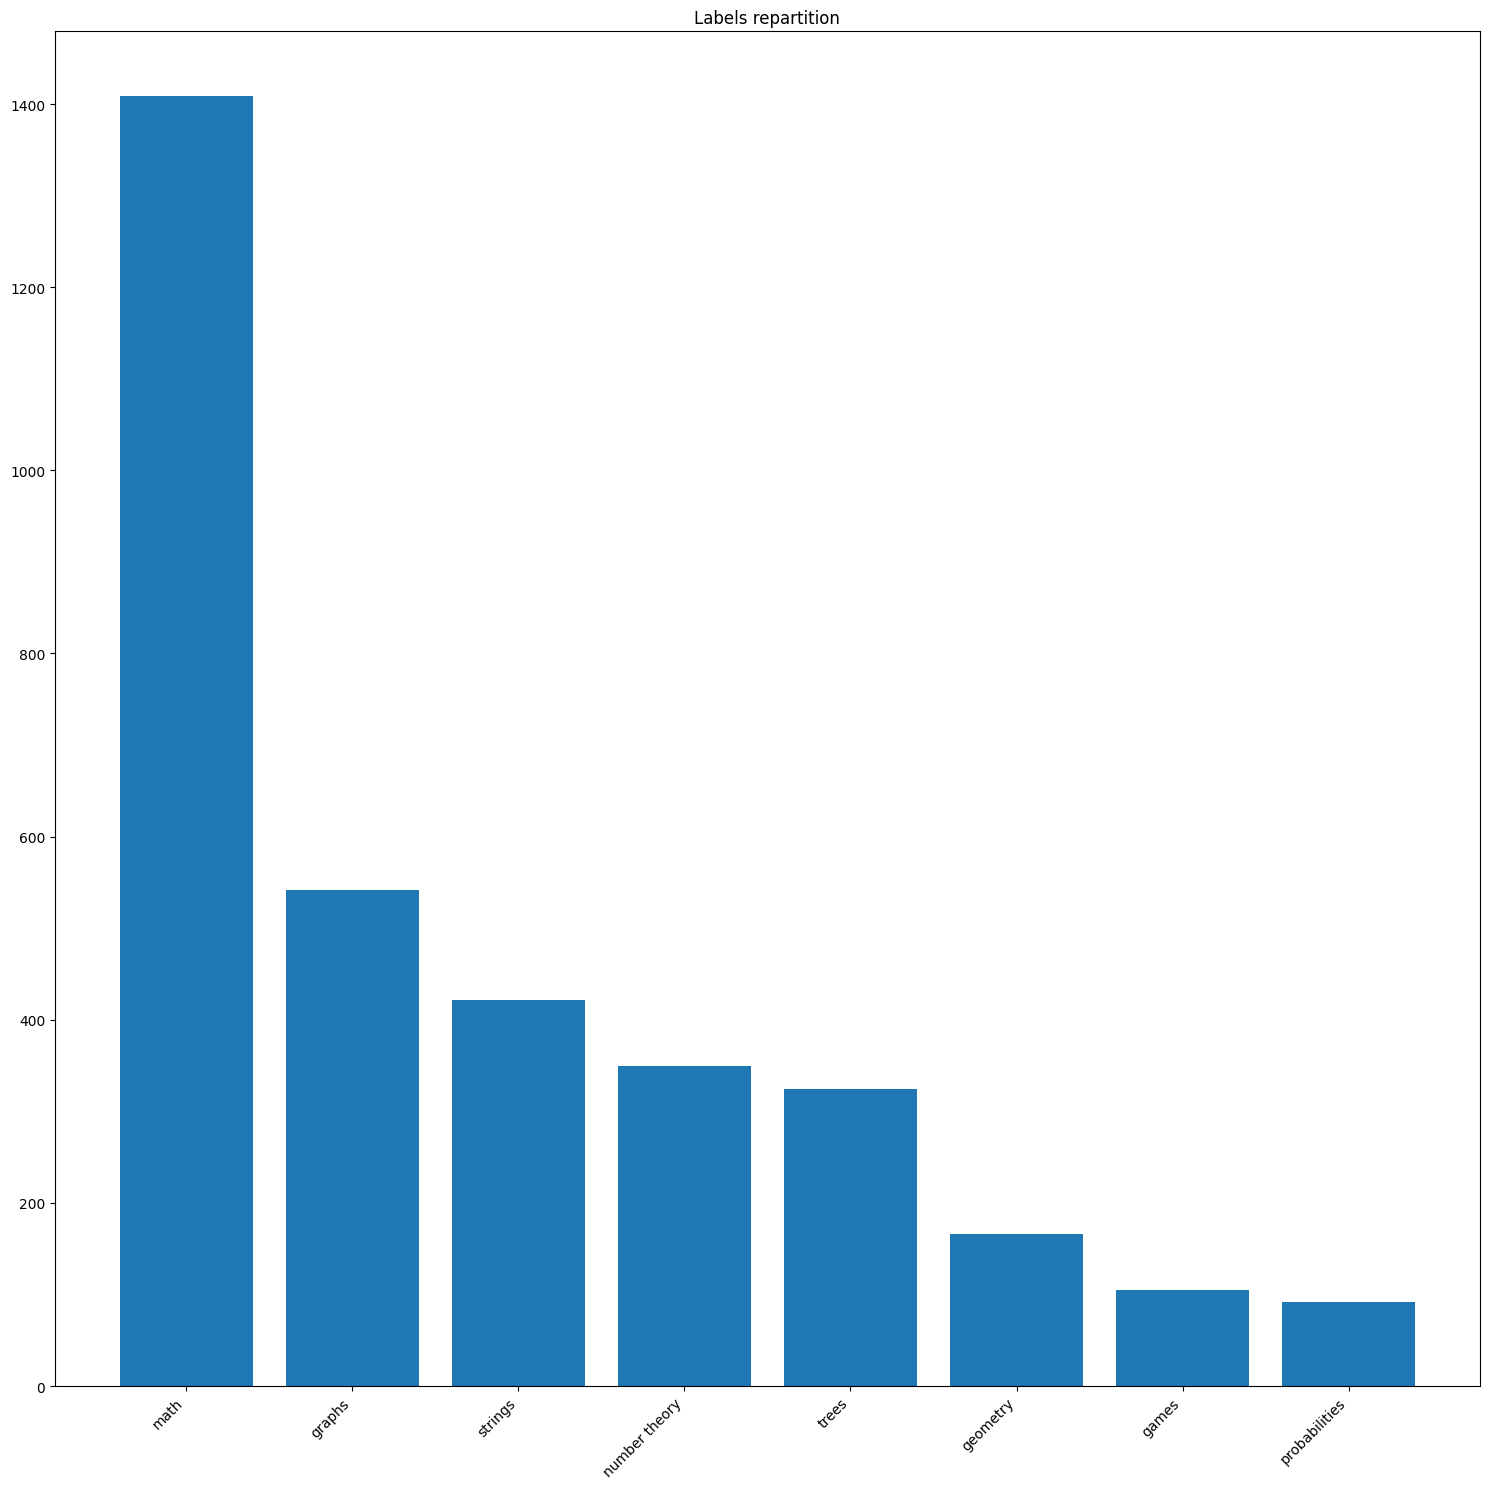

In [4]:

pltUtils.plot_tags_names_repartition(dataframe["tags"])
probability_count = sum("probabilities" in tags for tags in dataframe["tags"])

In [5]:
config = TrainingConfig(tags=['math', 'graphs', 'strings', 'number theory', 'trees', 'geometry', 'games', 'probabilities'])
dataframe = build_dataframe_from_json(jsonList,config)
dataframe  = dataframe.dropna(subset="difficulty")
#dataframe = reduce_math(dataframe,300)
codeFeatureExtractor = SourceCodeFeatureExtractor()
codeFeatureExtractor.transform(dataframe)
codeFeatureExtractor.add_feature_to_keep("difficulty")
print(f"extra features {codeFeatureExtractor.get_training_features()}")
extra_features = dataframe[codeFeatureExtractor.get_training_features()]
extra_features_clean = extra_features.astype(float)

X_extra = csr_matrix(extra_features_clean.values)

tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 3),stop_words='english',
    lowercase=True,
    max_df=0.8,
    min_df=5,
    sublinear_tf=True,
    strip_accents='unicode')
X = tfidf.fit_transform(dataframe['description_and_code'])

X = hstack([X,X_extra])

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataframe['tags'])

X_train, X_test, y_train, y_test = multilabel_stratified_split(X,y,test_size=0.2)
X_train,y_train  = multilabel_oversample(X_train,y_train,50)

clf = OneVsRestClassifier(LGBMClassifier(n_estimators=200, class_weight='balanced', random_state=42))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

extra features ['has_math_terms', 'difficulty', 'has_comparison_operator', 'has_geometry_keywords', 'has_probability_terms_in_desc', 'num_loops']
[LightGBM] [Info] Number of positive: 82, number of negative: 2042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62258
[LightGBM] [Info] Number of data points in the train set: 2124, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\francois.le-guernic\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\francois.le-guernic\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
X_train, X_test, y_train, y_test = multilabel_stratified_split(X,y,test_size=0.2)
print(y_train.sum(axis=0)/len(y_train))
print(y_test.sum(axis=0)/len(y_test))

[0.0386064  0.06167608 0.20386064 0.5240113  0.1299435  0.03436911
 0.15819209 0.12146893]
[0.03759398 0.06203008 0.20300752 0.52443609 0.12969925 0.03383459
 0.15789474 0.12218045]


c:\Users\francois.le-guernic\Desktop\CodeClassification\utils\training_utils.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(confusions.index, rotation=45, ha='right')
c:\Users\francois.le-guernic\Desktop\CodeClassification\utils\training_utils.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(confusions.index, rotation=45, ha='right')
c:\Users\francois.le-guernic\Desktop\CodeClassification\utils\training_utils.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(confusions.index, rotation=45, ha='right')
c:\Users\francois.le-guernic\Desktop\CodeClassification\utils\training_utils.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks,

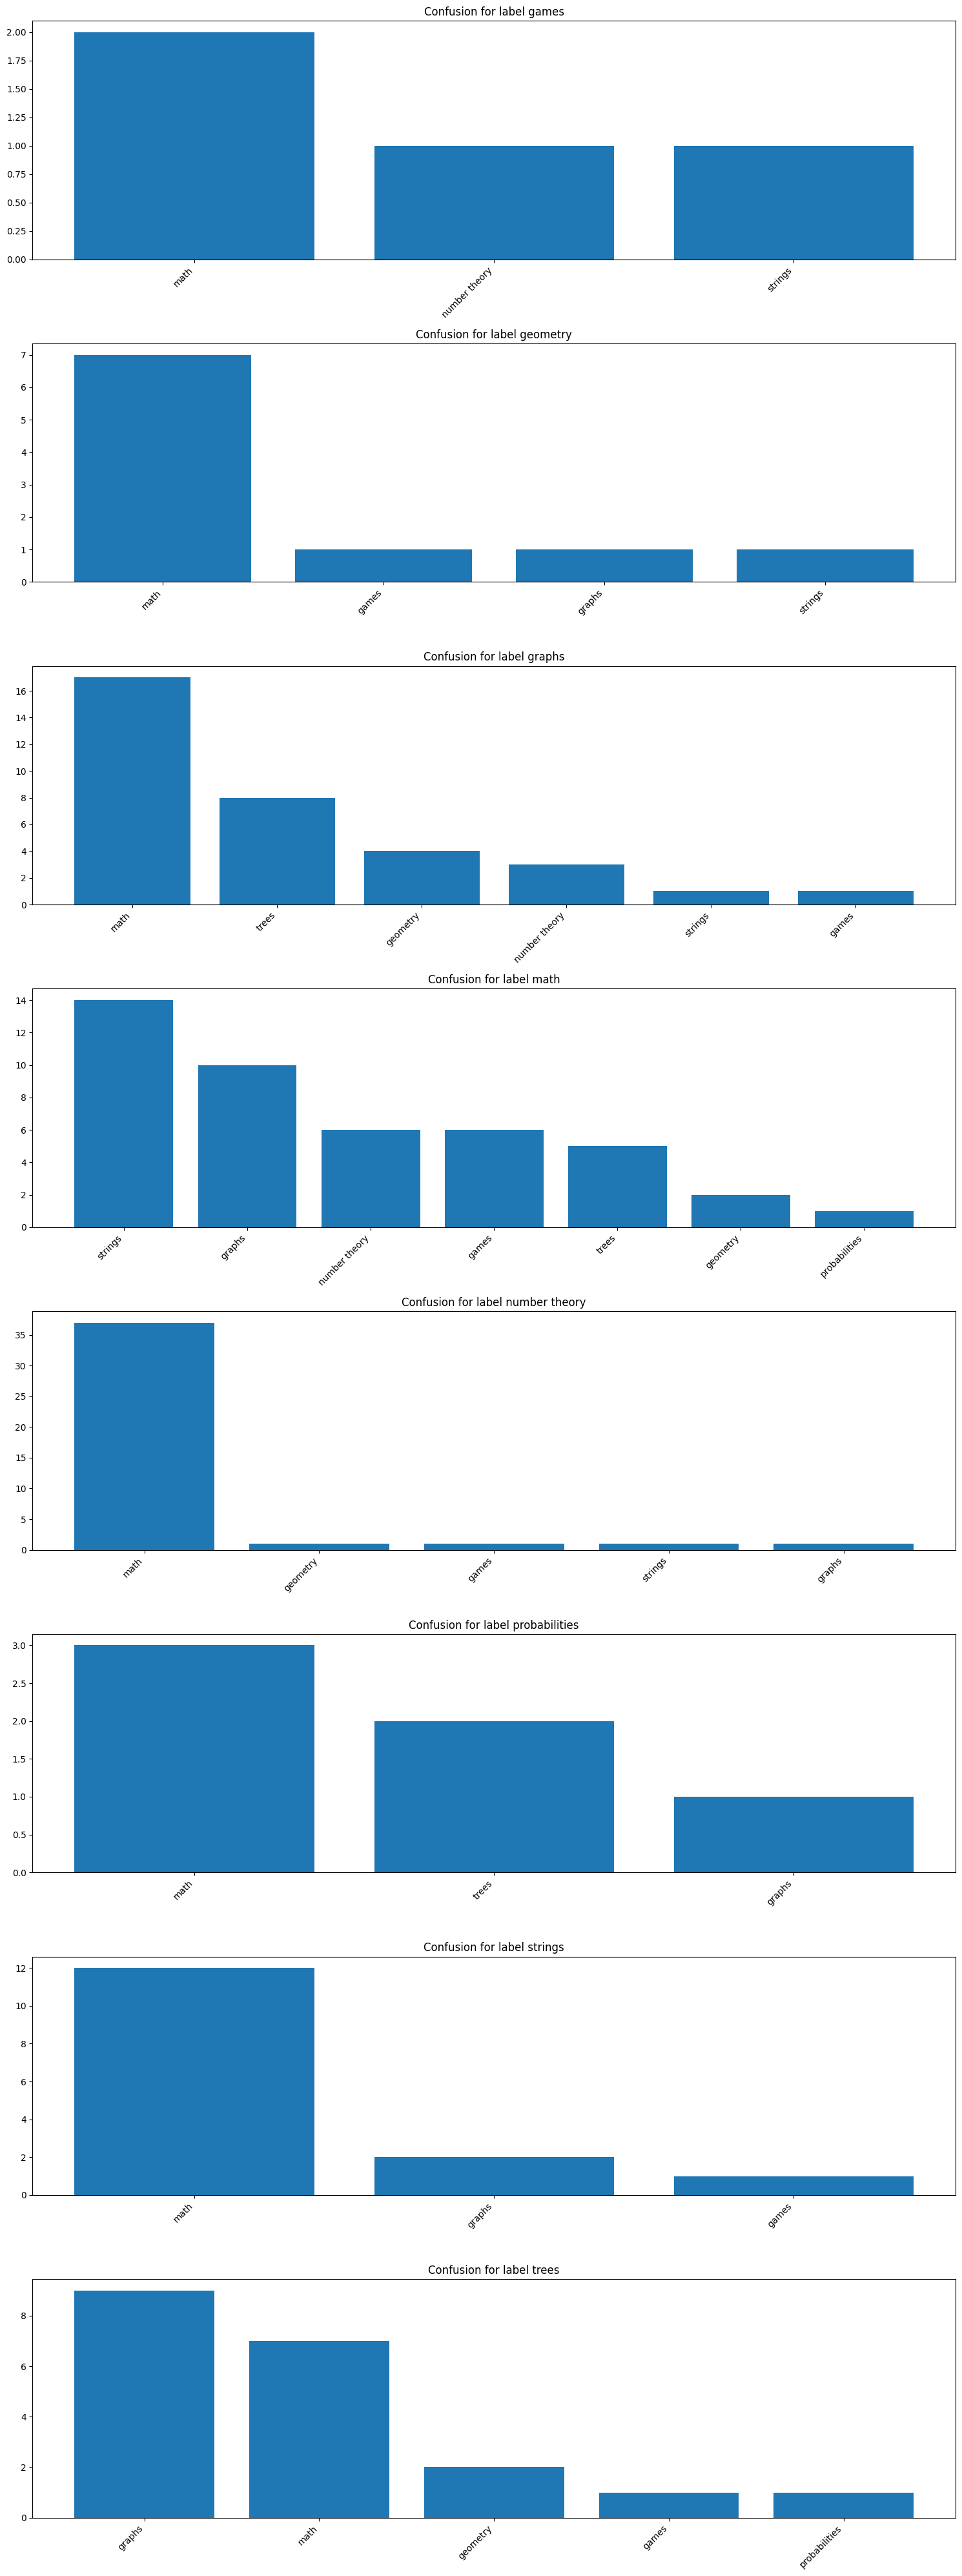

In [6]:
bar_plot_confusion(analyze_tag_confusions(y_test,y_pred,mlb.classes_))

In [10]:
nt = get_rows_containing_label("number theory",dataframe)
math = get_rows_containing_label("geometry",dataframe)


print(f"most frequent number theory : ", get_most_frequent_words(nt))
print(f"most frequent geometry: ", get_most_frequent_words(math))


most frequent number theory :  [('n', 688), ('number', 475), ('x', 456), ('b', 339), ('integers', 323), ('array', 315), ('k', 264), ('integer', 254), ('given', 227), ('numbers', 223), ('one', 220), ('two', 212), ('le', 203), ('find', 200), ('positive', 191), ('a_i', 168), ('gcd', 153), ('c', 124), ('sequence', 121), ('j', 121)]
most frequent geometry:  [('n', 224), ('points', 212), ('point', 205), ('one', 133), ('two', 125), ('coordinates', 91), ('x', 87), ('plane', 85), ('given', 84), ('b', 84), ('polygon', 83), ('number', 82), ('time', 76), ('find', 74), ('line', 64), ('possible', 63), ('three', 58), ('r', 56), ('equal', 54), ('segments', 54)]
